In [52]:
# This code is to take multiple on-chain data and test the unidirectional Garenger causality. For further information please refer to https://phdinds-aim.github.io/time_series_handbook/Preface/Preface.html
import json
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import acf, ccf, ccovf,adfuller, kpss
import warnings
warnings.filterwarnings("ignore")


In [53]:
# insert your API key, Start Date & End Date
current_date = datetime.now()
delta_date = 365
start_date = int(datetime.timestamp(current_date-timedelta(days = delta_date)))
end_date = int(datetime.timestamp(current_date))
API_KEY = '2B1pxzrRCwECISMvVhDJ5c3jtPi'

# make API request for Price
res_y = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_close',
    params={'a': 'BTC', 's': start_date, 'u': end_date, 'api_key': API_KEY})
df_y = pd.read_json(res_y.text, convert_dates=['t'])


url_list = ['https://api.glassnode.com/v1/metrics/indicators/sopr_less_155',
            'https://api.glassnode.com/v1/metrics/indicators/sopr_adjusted',
            'https://api.glassnode.com/v1/metrics/indicators/sopr_more_155',
            'https://api.glassnode.com/v1/metrics/indicators/sopr']

# make API request for X = STH-SOPR & Y = Price
i = 0
res_x = []
df_x = []
for url in url_list:
    res_x.append(requests.get(url,params={'a': 'BTC', 's': start_date, 'u': end_date, 'api_key': API_KEY}))
    df_x.append(pd.read_json(res_x[i].text, convert_dates=['t']))
    i = i+1

# concat all values from dfs
df = df_y['v']
for dfx in df_x:
    df = pd.concat([df,dfx['v']], axis=1)
df.columns =['PRICE']+ [url.split("/")[-1:][0].upper() for url in url_list]
print(df.head(5))

          PRICE  SOPR_LESS_155  SOPR_ADJUSTED  SOPR_MORE_155      SOPR
0  16553.336987       0.995636       0.865601       0.387162  0.928425
1  16620.819927       0.995300       0.982933       0.601646  0.993143
2  16693.930009       1.001047       0.993102       0.745340  0.997344
3  16682.715885       0.995557       0.971039       0.545586  0.987792
4  16865.159755       0.999431       0.968075       0.558374  0.985428


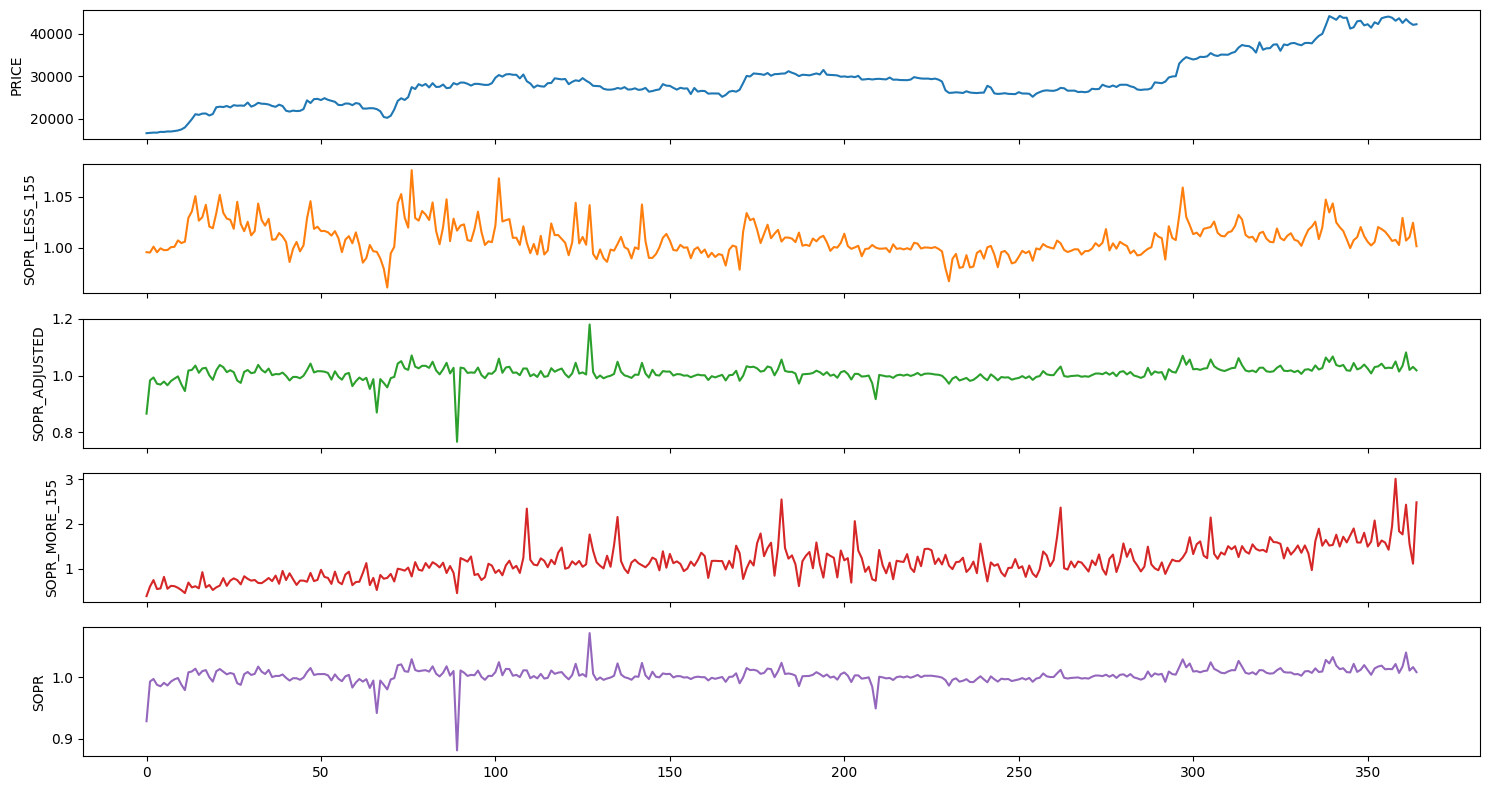

In [54]:
fig,ax = plt.subplots(df.shape[1], figsize=(15,8), sharex=True)
df.plot(subplots=True, legend=False, ax=ax)
for a in range(len(ax)): 
    ax[a].set_ylabel(df.columns[a])
ax[-1].set_xlabel('')
plt.tight_layout()
plt.show()

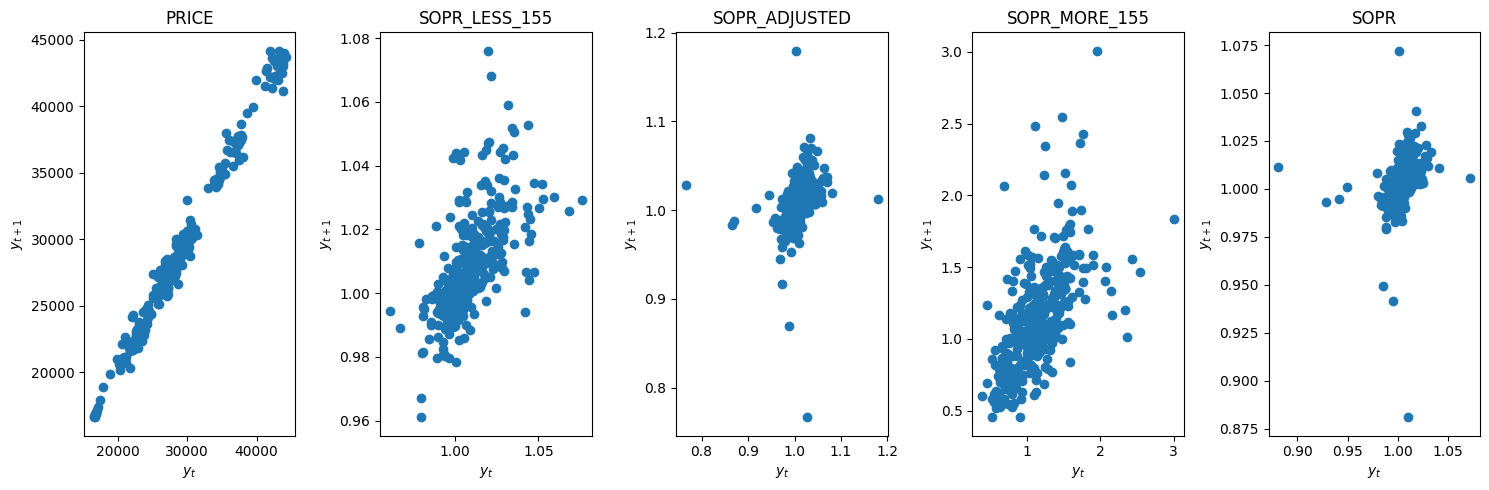

In [55]:
#lag plots to quickly check for stationarity

def lag_plots(data_df):
    f, ax= plt.subplots(1, data_df.shape[1], figsize=(15, 5))
    for i in range(data_df.shape[1]):
        lag_plot(data_df[data_df.columns[i]], ax=ax[i])
        ax[i].set_title(data_df.columns[i]);
        ax[i].set_ylabel('$y_{t+1}$');
        ax[i].set_xlabel('$y_t$');
    plt.tight_layout()
lag_plots(df)

In [56]:
#Use KPSS and ADF teststo conclusively check for stationarity
def kpss_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data_df.columns: 
        kpss_res = kpss(data_df[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['2.5%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    kpss_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    kpss_res_df = kpss_res_df.round(4)
    return kpss_res_df

In [57]:
kpss_test(df)

,PRICE,SOPR_LESS_155,SOPR_ADJUSTED,SOPR_MORE_155,SOPR
Test statistic,0.3226,0.3165,0.2323,0.3211,0.2472
p-value,0.0100,0.0100,0.0100,0.0100,0.0100
Critical value - 1%,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760,0.1760,0.1760,0.1760
Critical value - 5%,0.1460,0.1460,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.1190,0.1190


In [58]:
def adf_test(data_df):
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data_df.columns: 
        adf_res = adfuller(data_df[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data_df.columns).T
    adf_res_df = adf_res_df.round(4)
    return adf_res_df

In [59]:
df_adf = adf_test(df)
adf_test(df)

,PRICE,SOPR_LESS_155,SOPR_ADJUSTED,SOPR_MORE_155,SOPR
Test statistic,-0.8509,-3.0927,-5.9919,-1.6002,-6.1154
p-value,0.8037,0.0271,0.0000,0.4835,0.0000
Critical value - 1%,-3.4484,-3.4492,-3.4486,-3.4487,-3.4486
Critical value - 5%,-2.8695,-2.8699,-2.8696,-2.8696,-2.8696
Critical value - 10%,-2.5710,-2.5712,-2.5711,-2.5711,-2.5711


In [60]:
# use diff for non-stationary variables 
i = 0
diff_applied = []
for p_value in df_adf.iloc[1,:]:
    if p_value > 0.05:
        df.iloc[:,i] = df.iloc[:,i]- df.iloc[:,i].shift(1)
        diff_applied.append(True)
    else:
        diff_applied.append(False)
    i = i+1
df = df.dropna()
print(diff_applied)

[True, False, False, True, False]


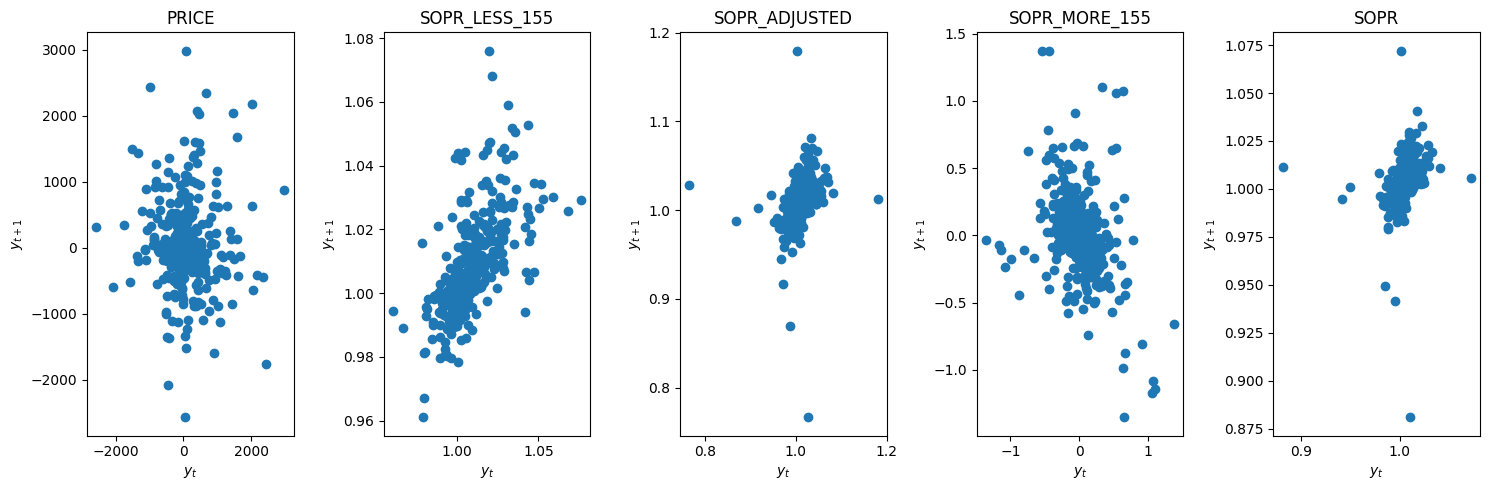

In [61]:
lag_plots(df)

In [62]:
kpss_test(df)

,PRICE,SOPR_LESS_155,SOPR_ADJUSTED,SOPR_MORE_155,SOPR
Test statistic,0.1167,0.3233,0.2498,0.0936,0.2732
p-value,0.1000,0.0100,0.0100,0.1000,0.0100
Critical value - 1%,0.2160,0.2160,0.2160,0.2160,0.2160
Critical value - 2.5%,0.1760,0.1760,0.1760,0.1760,0.1760
Critical value - 5%,0.1460,0.1460,0.1460,0.1460,0.1460
Critical value - 10%,0.1190,0.1190,0.1190,0.1190,0.1190


In [63]:
adf_test(df)

,PRICE,SOPR_LESS_155,SOPR_ADJUSTED,SOPR_MORE_155,SOPR
Test statistic,-19.9021,-3.0982,-5.9687,-7.5322,-6.0715
p-value,0.0000,0.0267,0.0000,0.0000,0.0000
Critical value - 1%,-3.4485,-3.4493,-3.4486,-3.4493,-3.4486
Critical value - 5%,-2.8695,-2.8699,-2.8696,-2.8699,-2.8696
Critical value - 10%,-2.5710,-2.5712,-2.5711,-2.5712,-2.5711


Maximum at: 0.0 (in $days$)


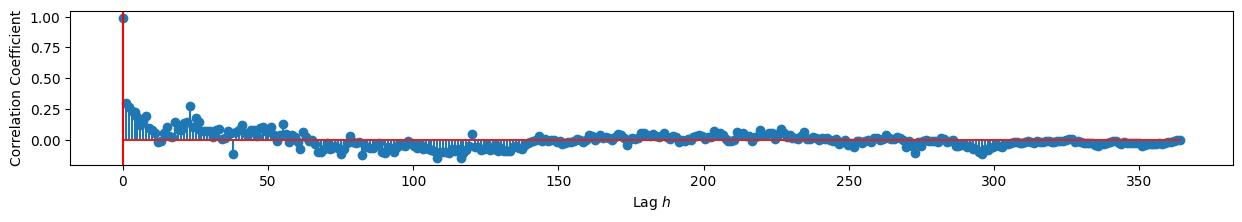

In [66]:
samp_rate = 1
dur = len(df['PRICE'])
plt.subplots(figsize=(15, 2))
ccf_12 = ccf(df['SOPR'], df['SOPR_ADJUSTED'], unbiased=False)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag $h$')
plt.stem(np.linspace(0, dur, samp_rate*dur), ccf_12)
peak = np.argmax(ccf_12)/samp_rate
plt.axvline(peak, c='r')
print('Maximum at:', peak, '(in $days$)')